In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KernelDensity, KNeighborsClassifier

In [3]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV

## Load Iris Dataset

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_dataset = pd.DataFrame(iris["data"], columns=iris["feature_names"])
iris_dataset["y"] = iris["target"]
iris_dataset["y"] = iris_dataset["y"].map(dict(enumerate(iris.target_names)))

In [5]:
print(f"Number of instances: {len(iris_dataset)}")

Number of instances: 150


## Split Train/Test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    iris_dataset.drop("y", axis=1),
    iris_dataset["y"],
    test_size=0.3,
    random_state=51,
    stratify=iris_dataset["y"],
)

## KDE Classifier Wrapper

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"

    def __init__(self, bandwidth=0.1, kernel="gaussian"):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.kdes_ = {}
        for c in self.classes_:
            X_cls = X[y == c]
            kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth)
            kde.fit(X_cls)
            self.kdes_[c] = kde
        return self

    def _log_prob(self, X):
        # For each class, compute the log probability density function
        logs = [self.kdes_[c].score_samples(X) for c in self.classes_]
        return np.vstack(logs).T  # shape (n_samples, n_classes)

    def predict(self, X):
        log_probs = self._log_prob(X)
        # Get the class with the highest log probability
        return self.classes_[np.argmax(log_probs, axis=1)]

    def predict_proba(self, X):
        log_probs = self._log_prob(X)
        probs = np.exp(log_probs)
        return probs / probs.sum(
            axis=1, keepdims=True
        )  # Normalize to get probabilities

## Hyperparameters Grid

In [28]:
params_grid = {
    "knn": {
        "model": KNeighborsClassifier,
        "params": {
            "clf__n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15],
        },
    },
    "rda": {
        "model": LinearDiscriminantAnalysis,
        "params": {
            "clf__solver": ["lsqr"],  # Using lsqr solver which supports shrinkage
            "clf__shrinkage": np.arange(0, 1.25, 0.25),
        },
    },
    "kde": {
        "model": KDEClassifier,
        "params": {
            "clf__bandwidth": np.arange(0.1, 1.1, 0.1),
            "clf__kernel": ["gaussian", "tophat"],
        },
    },
}

## Pipelines

### Feature Scaling Transformer

In [29]:
# Define the columns to be transformed
continuous_columns = X_train.select_dtypes(include=["float64"]).columns

# Crear el ColumnTransformer for only continuous columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
    ]
)

### Pipeline creator and training

In [ ]:
def create_pipeline(params_grid):
    model_instance = params_grid["model"]()

    pipelines = {
        "original": Pipeline([("scaler", preprocessor), ("clf", model_instance)]),
        "pca1": Pipeline(
            [
                ("scaler", preprocessor),
                ("pca", PCA(n_components=0.73)),
                ("clf", model_instance),
            ]
        ),
        "pca2": Pipeline(
            [
                ("scaler", preprocessor),
                ("pca", PCA(n_components=0.96)),
                ("clf", model_instance),
            ]
        ),
        "pca3": Pipeline(
            [
                ("scaler", preprocessor),
                ("pca", PCA(n_components=0.995)),
                ("clf", model_instance),
            ]
        ),
        "sfs": Pipeline(
            [
                ("scaler", preprocessor),
                (
                    "sfs",
                    SequentialFeatureSelector(
                        model_instance,
                        direction="forward",
                        n_jobs=-1,
                        cv=10,
                        scoring="accuracy",
                    ),
                ),
                ("clf", model_instance),
            ]
        ),
    }

    return pipelines


def train_pipelines_CV(params_grid, X_train, y_train, scoring="roc_auc_ovr"):
    # Multi-class AUC for Multi-class AUC
    pipelines = create_pipeline(params_grid)

    best_estimators = {}
    for name, pipe in pipelines.items():  # Unpack the tuple
        print(f"Training pipeline: {name}")
        gs = GridSearchCV(
            pipe,
            params_grid["params"],
            scoring=scoring,
            cv=10,
        )
        gs.fit(X_train, y_train)
        best_estimators[name] = gs.best_estimator_

    return best_estimators

In [31]:
knn_opt = train_pipelines_CV(params_grid["knn"], X_train, y_train)
rda_opt = train_pipelines_CV(params_grid["rda"], X_train, y_train)
kde_opt = train_pipelines_CV(params_grid["kde"], X_train, y_train, scoring="accuracy")

Training pipeline: original
Training pipeline: pca1
Training pipeline: pca2
Training pipeline: pca3
Training pipeline: sfs
Training pipeline: original
Training pipeline: pca1
Training pipeline: pca2
Training pipeline: pca3
Training pipeline: sfs
Training pipeline: original
Training pipeline: pca1
Training pipeline: pca2
Training pipeline: pca3
Training pipeline: sfs


A lo largo del ejercicio, surgió un problema a la hora de realizar el entrenamiento con el wrapper KDEClassifier. Por lo que se puede observar, esto sucede dado que el pipeline detecta (por alguna razón que no he conseguido averiguar) que el modelo KDECLassifier no es un `classifier`y es un `regressor`, por lo que no puede hacer la llamada a `predict_proba` para poder realizar el cálculo de la métrica `roc_auc_ovr`. Por esto mismo, se decide incorporar una métrica de clasificación que no necesite el uso de `predict_proba`, como puede ser `accuracy` (esto no es problema para este dataset, dado que las clases están balanceadas) para los pipelines que utilicen `KDECLassifier`

---

## Evaluation

In [72]:
from sklearn.metrics import confusion_matrix

In [147]:
def plot_roc_auc(y_test, model):
    y_pred_probas = {
        "original": model["original"].predict_proba(X_test),
        "pca1": model["pca1"].predict_proba(X_test),
        "pca2": model["pca2"].predict_proba(X_test),
        "pca3": model["pca3"].predict_proba(X_test),
        "sfs": model["sfs"].predict_proba(X_test),
    }

    aucs = {
        "original": roc_auc_score(y_test, y_pred_probas["original"], multi_class="ovr"),
        "pca1": roc_auc_score(y_test, y_pred_probas["pca1"], multi_class="ovr"),
        "pca2": roc_auc_score(y_test, y_pred_probas["pca2"], multi_class="ovr"),
        "pca3": roc_auc_score(y_test, y_pred_probas["pca3"], multi_class="ovr"),
        "sfs": roc_auc_score(y_test, y_pred_probas["sfs"], multi_class="ovr"),
    }

    fpr_original, tpr_original, _ = roc_curve(
        y_test, y_pred_probas["original"][:, 2], pos_label="virginica"
    )
    fpr_pca1, tpr_pca1, _ = roc_curve(
        y_test, y_pred_probas["pca1"][:, 2], pos_label="virginica"
    )
    fpr_pca2, tpr_pca2, _ = roc_curve(
        y_test, y_pred_probas["pca2"][:, 2], pos_label="virginica"
    )
    fpr_pca3, tpr_pca3, _ = roc_curve(
        y_test, y_pred_probas["pca3"][:, 2], pos_label="virginica"
    )
    fpr_sfs, tpr_sfs, _ = roc_curve(
        y_test, y_pred_probas["sfs"][:, 2], pos_label="virginica"
    )

    sns.set_style("white")

    sns.lineplot(
        x=fpr_original,
        y=tpr_original,
        label=f"AUC Original: {aucs['original']:.2f}",
        color="#A3C4F3",
    )
    sns.lineplot(
        x=fpr_pca1,
        y=tpr_pca1,
        label=f"AUC PCA (73%): {aucs['pca1']:.2f}",
        color="#FFB6B9",
    )
    sns.lineplot(
        x=fpr_pca2,
        y=tpr_pca2,
        label=f"AUC PCA (96%): {aucs['pca2']:.2f}",
        color="#B5EAD7",
    )
    sns.lineplot(
        x=fpr_pca3,
        y=tpr_pca3,
        label=f"AUC PCA (99.5%): {aucs['pca3']:.2f}",
        color="#9BB7F7",
    )
    sns.lineplot(
        x=fpr_sfs,
        y=tpr_sfs,
        label=f"AUC SFS: {aucs['sfs']:.2f}",
        color="#EACCB5",
    )

    plt.plot([0, 1], [0, 1], color="#E5E1DA", linestyle="--")
    # plt.fill_between(fpr, tpr, color='#FF8080', alpha=0.05)
    plt.title(f"ROC Curve for {model['original'].steps[1][1].__class__.__name__}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.text(0.6, 0.5, "Baseline")
    plt.legend()
    plt.gca().set_frame_on(False)
    plt.show()
    plt.close()


def plot_confusion_matrices(y_test, model):
    y_preds = {
        "original": model["original"].predict(X_test),
        "pca1": model["pca1"].predict(X_test),
        "pca2": model["pca2"].predict(X_test),
        "pca3": model["pca3"].predict(X_test),
        "sfs": model["sfs"].predict(X_test),
    }

    class_labels = model["original"].classes_

    # Create a figure with 5 subplots in a single row
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    titles = ["Original", "PCA (73%)", "PCA (96%)", "PCA (99.5%)", "SFS"]

    for i, (name, title) in enumerate(zip(y_preds.keys(), titles)):
        cm = confusion_matrix(y_test, y_preds[name])
        sns.heatmap(
            cm,
            annot=True,
            cmap="Blues",
            fmt="g",
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=axes[i],
        )
        axes[i].set_title(f"{title}")

        if i == 0:  # Only add y-label to the first plot
            axes[i].set_ylabel("True Label")

        axes[i].set_xlabel("Predicted Label")

    plt.suptitle(
        f"Confusion Matrices for {model['original'].steps[1][1].__class__.__name__}",
        fontsize=16,
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    plt.close()

    # Print classification reports for each model variant
    print("\n--- Classification Reports ---")
    for name, title in zip(y_preds.keys(), titles):
        print(f"\n{title} Model:")
        print(classification_report(y_test, y_preds[name]))

def plot_pca_scree(X):
    pca = PCA()
    pca.fit(X)
    
    plt.figure(figsize=(10, 6))
    
    plt.bar(
        range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_,
        alpha=0.7,
        align='center',
        label='Individual explained variance'
    )
    
    # Plot cumulative explained variance
    plt.plot(
        range(1, len(pca.explained_variance_ratio_) + 1),
        np.cumsum(pca.explained_variance_ratio_),
        color="#D76767",
        label='Cumulative explained variance'
    )
    
    # Add threshold lines for reference
    plt.axhline(y=0.73, color='k', linestyle=':', alpha=0.3, label='73% threshold')
    plt.axhline(y=0.96, color='k', linestyle='-.', alpha=0.3, label='96% threshold')
    plt.axhline(y=0.995, color='k', linestyle='--', alpha=0.3, label='99.5% threshold')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component number')
    plt.title('Scree Plot for PCA Components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for i, v in enumerate(pca.explained_variance_ratio_):
        plt.text(i+1, v + 0.01, f'{v:.2%}', ha='center')
    
    plt.show()

In [113]:
y_pred_rda = rda_opt["original"].predict(X_test)
y_pred_knn = knn_opt["original"].predict(X_test)
y_pred_kde = kde_opt["original"].predict(X_test)

### KNN

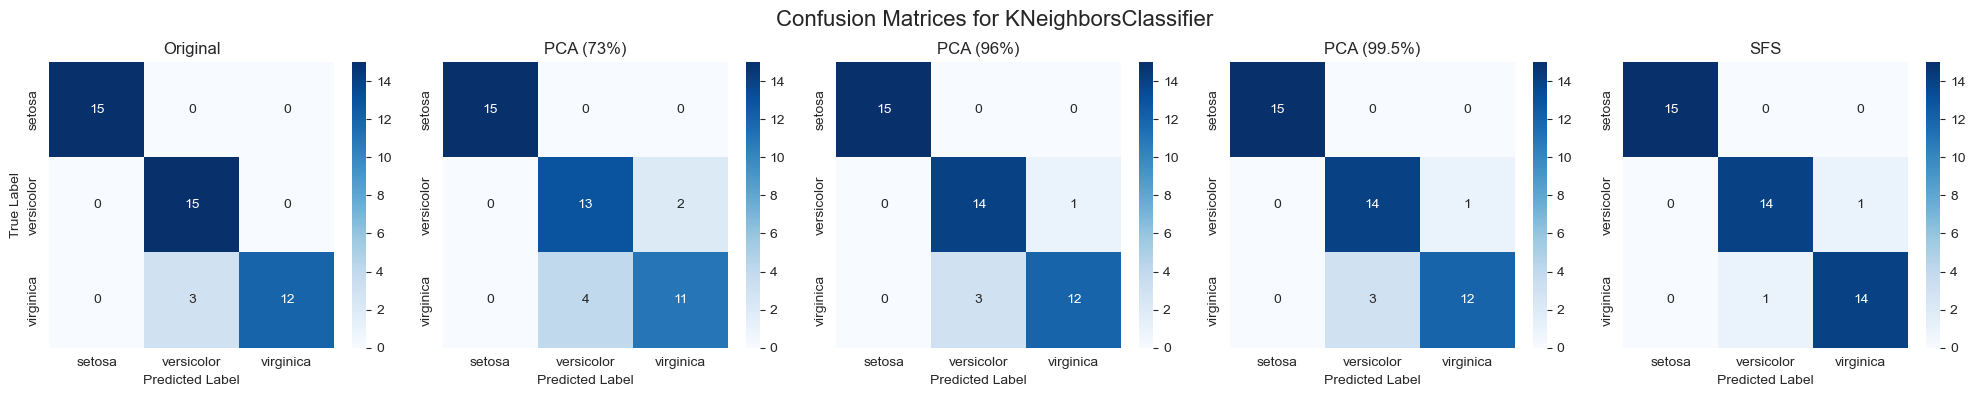


--- Classification Reports ---

Original Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.83      1.00      0.91        15
   virginica       1.00      0.80      0.89        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45


PCA (73%) Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.76      0.87      0.81        15
   virginica       0.85      0.73      0.79        15

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45


PCA (96%) Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88 

In [115]:
plot_confusion_matrices(y_test, knn_opt)

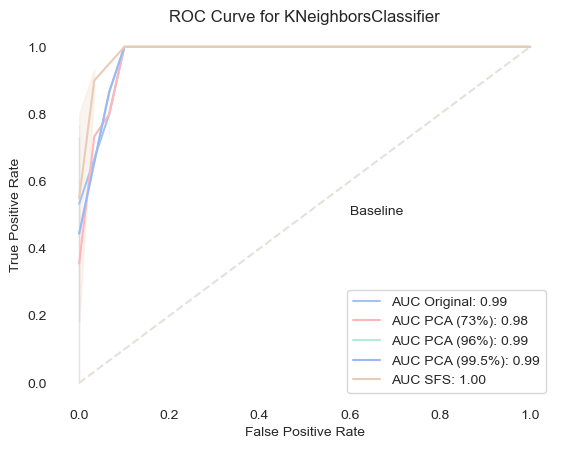

In [116]:
plot_roc_auc(y_test, knn_opt)

### RDA

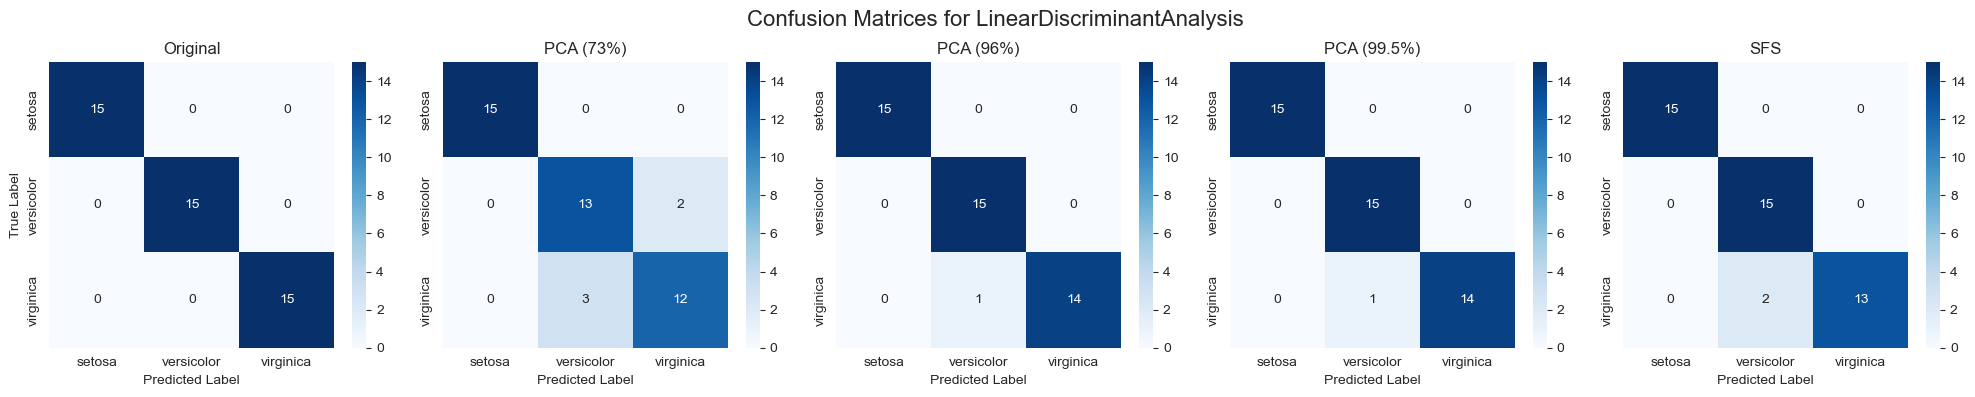


--- Classification Reports ---

Original Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      1.00      1.00        15
   virginica       1.00      1.00      1.00        15

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


PCA (73%) Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.81      0.87      0.84        15
   virginica       0.86      0.80      0.83        15

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45


PCA (96%) Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97 

In [117]:
plot_confusion_matrices(y_test, rda_opt)

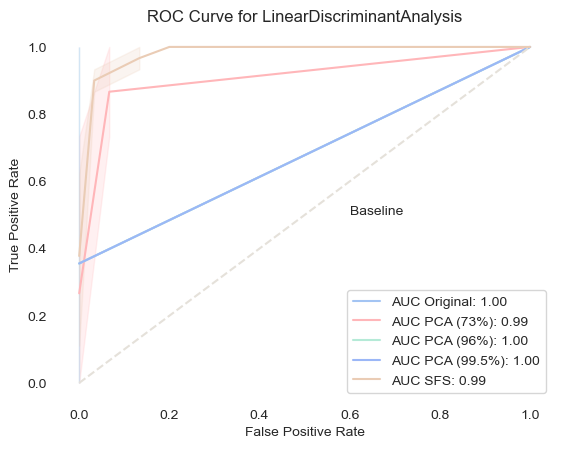

In [118]:
plot_roc_auc(y_test, rda_opt)

### KDE

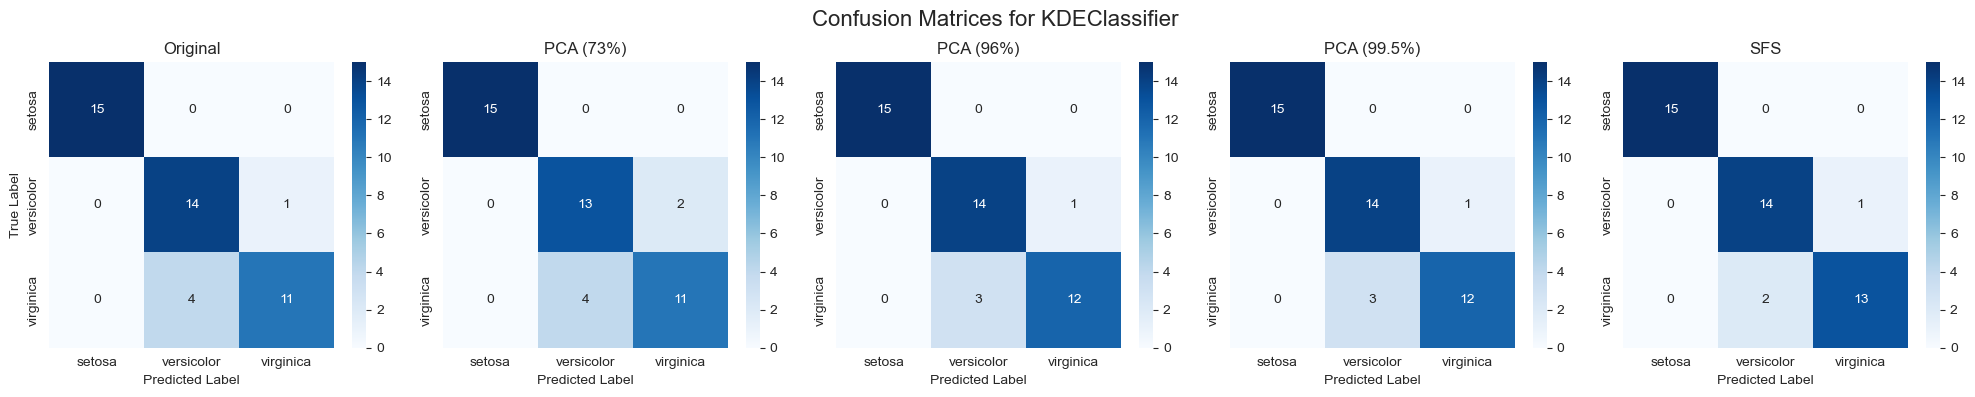


--- Classification Reports ---

Original Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45


PCA (73%) Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.76      0.87      0.81        15
   virginica       0.85      0.73      0.79        15

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45


PCA (96%) Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88 

In [119]:
plot_confusion_matrices(y_test, kde_opt)

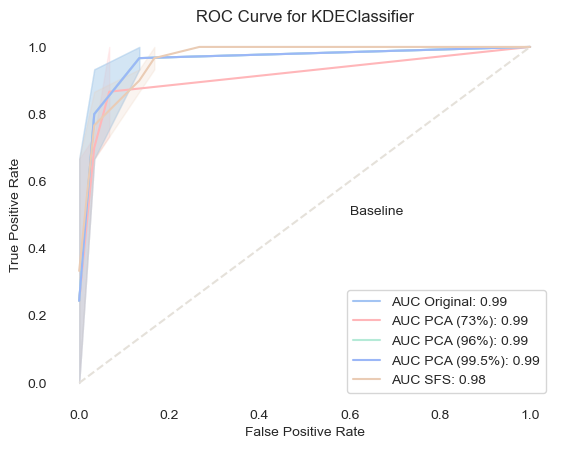

In [120]:
plot_roc_auc(y_test, kde_opt)

## Informe Final

### Scree plot

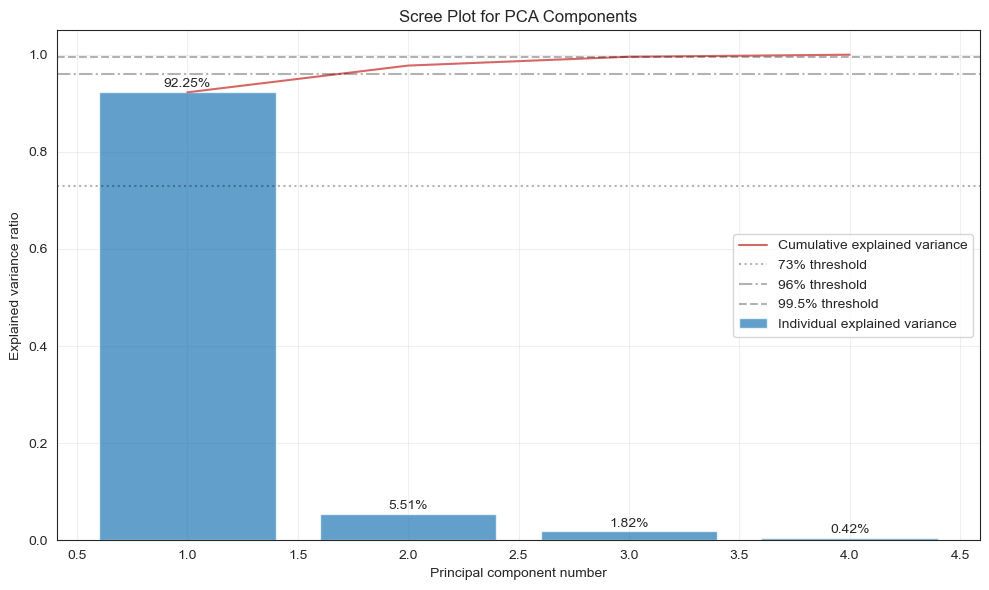

In [146]:
plot_pca_scree(X_train)

El `scree plot` muestra la varianza relativa y la varianza relativa acumulada a medida que se van añadiendo componentes principales. En el caso de un PCA para un 73% de varianza relativa, esto supone que la dimensionalidad se reduce a una componente principal. En el caso de un PCA que explique un 96% de la varianza, se trataría de una reducción a dos componentes principales, y por último, el caso de un PCA al 99.5% implicaría una reducción de dimensiones equivalente a utilizar tres componentes principales.

### Hiperparámetros elegidos (uno por algoritmo).

#### KNN

En el caso de K-NN, el modelo con mayor AUC es el que utilizó selección de características secuencial hacia delante (SFS) con un AUC de 1.00. Además, es el modelo que presenta mayor valor en la métrica F1-Score. 

In [176]:
# Access and print KDE hyperparameters
knn_model = knn_opt['sfs'].named_steps['clf']
print("\n[KNN Hyperparameters]")
print(f"K: {knn_model.n_neighbors}")


[KNN Hyperparameters]
K: 13


El hiperparámetro óptimo para K-NN resulta ser un total de 13 vecinos cercanos.

#### RDA

En el caso del clasificador por RDA, los pipelines de reducción de dimension que mayor valor presentan de AUC (1.00) son, el original (sin reducción de dimensionalidad) y el PCA del 99.6% de varianza explicada. Para poder determinar el modelo óptimo definitivo, se usa la métrica Weighted Avg F1-Score, resultando ser el pipeline sin reducción de dimensión el más óptimo, con un valor de 1.00.

In [180]:
# Access and print KDE hyperparameters
rda_model = rda_opt['original'].named_steps['clf']
print("\n[RDA Hyperparameters]")
print(f"shrinkage: {rda_model.shrinkage}")


[RDA Hyperparameters]
shrinkage: 0.0


Finalmente, el modelo óptimo presenta un shrinkage de 0; es decir, RDA se convierte en un clasificador LDA.

#### KDE

En el caso de KDEClassifier, dado que el AUC para cada variación de reducción de dimensionalidad es equivalente (0.99), utilizaremos la métria F1-Score (media armónia entre precision y recall) para determinar el pipeline óptimo (y sus correspondientes hiperparámetros óptimos). En este caso, el pipeline donde se utiliza una selección de características hacia delante ofrece el mayor F1-Score (0.93 macro avg).

In [168]:
# Access and print KDE hyperparameters
kde_model = kde_opt['sfs'].named_steps['clf']
print("\n[KDE Hyperparameters]")
print(f"bandwidth: {kde_model.bandwidth}")
print(f"kernel: {kde_model.kernel}")


[KDE Hyperparameters]
bandwidth: 0.8
kernel: tophat


El clasificador KDE óptimo utiliza un bandwidth de 0.8 y un kernel de tipo tophat

### ROC en test entre los modelos

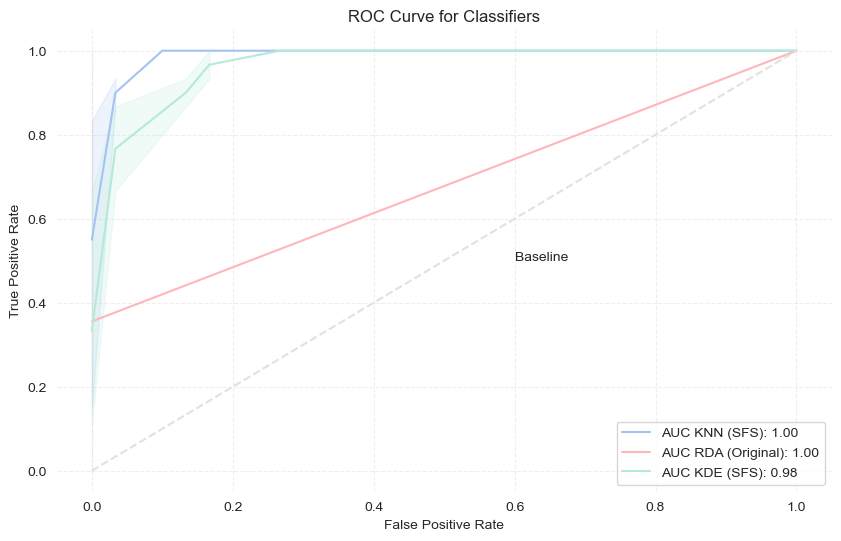

In [184]:

y_pred_probas = {
    "knn": knn_opt['sfs'].predict_proba(X_test),
    "rda": rda_opt['original'].predict_proba(X_test),
    "kde": kde_opt['sfs'].predict_proba(X_test),
}

aucs = {
    "knn": roc_auc_score(y_test, y_pred_probas["knn"], multi_class="ovr"),
    "rda": roc_auc_score(y_test, y_pred_probas["rda"], multi_class="ovr"),
    "kde": roc_auc_score(y_test, y_pred_probas["kde"], multi_class="ovr"),
}

fpr_knn, tpr_knn, _ = roc_curve(
    y_test, y_pred_probas["knn"][:, 2], pos_label="virginica"
)
fpr_rda, tpr_rda, _ = roc_curve(
    y_test, y_pred_probas["rda"][:, 2], pos_label="virginica"
)
fpr_kde, tpr_kde, _ = roc_curve(
    y_test, y_pred_probas["kde"][:, 2], pos_label="virginica"
)

plt.figure(figsize=(10, 6))

sns.set_style("white")

sns.lineplot(
    x=fpr_knn,
    y=tpr_knn,
    label=f"AUC KNN (SFS): {aucs['knn']:.2f}",
    color="#A3C4F3",
)
sns.lineplot(
    x=fpr_rda,
    y=tpr_rda,
    label=f"AUC RDA (Original): {aucs['rda']:.2f}",
    color="#FFB6B9",
)
sns.lineplot(
    x=fpr_kde,
    y=tpr_kde,
    label=f"AUC KDE (SFS): {aucs['kde']:.2f}",
    color="#B5EAD7",
)

plt.plot([0, 1], [0, 1], color="#E5E1DA", linestyle="--")
# plt.fill_between(fpr, tpr, color='#FF8080', alpha=0.05)
plt.title(f"ROC Curve for Classifiers")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0.6, 0.5, "Baseline")
plt.legend()
plt.gca().set_frame_on(False)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
plt.close()

Se puede visualizar las diferentes curvas ROC y valores AUC de los modelos óptimos seleccionados 

### Conclusiones: pipeline y algoritmo recomendados.

Finalmente, después de haber hecho la preselección de pipelines óptimos para cada algoritmo, se seleccionará el pipeline definitivo. Para ello se tendrá en cuenta la métrica AUC, y si fuera equivalente entre los modelos, la métrica F1-Score (como en la selección anterior).

Los pipeline con mayor AUC (1.0) son K-NN con SFS y RDA con todas las variables. Sin embargo, RDA con todas las variables presenta el mejor valor de F1-Score (y de todas las métricas, las cuales se encuentran a 100%).

Dada la simplicidad computacional, la interpretabilidad y la capacidad de generalización de RDA (dado que se trata de un modelo lineal), se escoge como pipeline óptimo.